In [ ]:
import os
import numpy as np
import scipy.io
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import h5py
import os
import cv2

data_dir = "/kaggle/input/figshare-brain-tumor-dataset/dataset/data"
total_images = 3064  

X_tumor = []
Y_tumor_mask = []
tumour_labels = []  # Store labels in a list

for i in range(1, total_images + 1):
    filename = str(i) + ".mat"
    data = h5py.File(os.path.join(data_dir, filename), "r")

    # Extract tumor image
    image = np.array(data["cjdata"]["image"])
    image = cv2.resize(image, (128, 128))  # Resize for U-Net input
    image = image / 255.0  # Normalize pixel values
    X_tumor.append(image)

    # Extract tumor mask
    mask = np.array(data["cjdata"]["tumorMask"])  # Get segmentation mask
    mask = cv2.resize(mask, (128, 128))
    mask = (mask > 0).astype(np.uint8)  # Convert to binary mask (0 or 1)
    Y_tumor_mask.append(mask)

    # Extract tumor label (1: Meningioma, 2: Glioma, 3: Pituitary Tumor)
    label = int(np.array(data["cjdata"]["label"])[0][0])  # Ensure integer type
    tumour_labels.append(label)  # Append label to list

# Convert lists to numpy arrays
X_tumor = np.array(X_tumor).reshape(-1, 128, 128, 1)  # Add channel dimension
Y_tumor_mask = np.array(Y_tumor_mask).reshape(-1, 128, 128, 1)  # Segmentation masks
tumour_labels = np.array(tumour_labels)  # Convert to NumPy array

print("Dataset Shapes:")
print("X_tumor:", X_tumor.shape)  # (N, 128,128, 1)
print("Y_tumor_mask:", Y_tumor_mask.shape)  # (N, 128,128, 1)
print("Tumor Labels:", tumour_labels.shape)  # (N,)
print("Unique Labels:", np.unique(tumour_labels))  # Check unique labels


Dataset Shapes:
X_tumor: (3064, 128, 128, 1)
Y_tumor_mask: (3064, 128, 128, 1)
Tumor Labels: (3064,)
Unique Labels: [1 2 3]


In [4]:
import numpy as np
import pandas as pd


def classify_tumor_severity(mask):
    total_pixels = mask.shape[0] * mask.shape[1]  # Total image area
    tumor_pixels = np.sum(mask > 0)  # Count white pixels (tumor area)

    tumor_percentage = (tumor_pixels / total_pixels) * 100

    if tumor_percentage <= 5:
        return "Mild"
    elif tumor_percentage <= 20:
        return "Moderate"
    else:
        return "Severe"

# Apply to all tumor masks
tumor_severity_labels = [classify_tumor_severity(mask.squeeze()) for mask in Y_tumor_mask]

# Print the number of each category
unique, counts = np.unique(tumor_severity_labels, return_counts=True)
severity_distribution = dict(zip(unique, counts))

# Create a DataFrame with Image ID and Severity Label
image_ids = list(range(1, len(tumor_severity_labels) + 1))
severity_df = pd.DataFrame({"Image_ID": image_ids, "Severity": tumor_severity_labels})

# Save the predictions
severity_df.to_csv("/kaggle/working/tumor_severity_predictions_new.csv", index=False)

print("Tumor severity predictions saved successfully!")


Tumor severity predictions saved successfully!


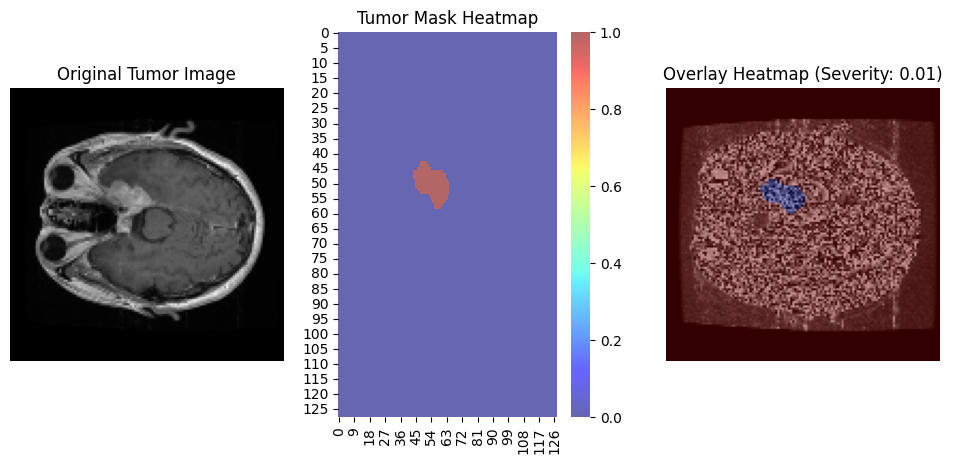

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

# Select a sample index
sample_idx = 100  # Change this to visualize different images

# Extract the image and mask
tumor_image = X_tumor[sample_idx].squeeze()  # Remove extra dimension
tumor_mask = Y_tumor_mask[sample_idx].squeeze()

# Convert grayscale tumor image to uint8 format (0-255)
tumor_image_uint8 = (tumor_image * 255).astype(np.uint8)  # Scale to 0-255
tumor_image_bgr = cv2.cvtColor(tumor_image_uint8, cv2.COLOR_GRAY2BGR)  # Convert to BGR

# Overlay Heatmap on Original Image (Ensure Both Images Are uint8)
overlay = cv2.addWeighted(tumor_image_bgr, 0.6, heatmap, 0.4, 0)


# Compute Tumor Severity (Size)
tumor_size = np.sum(tumor_mask)  # Count tumor pixels
severity_score = tumor_size / (128 * 128)  # Normalize by image size

# Create a Heatmap based on Tumor Mask
heatmap = cv2.applyColorMap((tumor_mask * 255).astype(np.uint8), cv2.COLORMAP_JET)


# Plot Results
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(tumor_image, cmap="gray")
plt.title("Original Tumor Image")
plt.axis("off")

plt.subplot(1, 3, 2)
sns.heatmap(tumor_mask, cmap="jet", alpha=0.6)
plt.title("Tumor Mask Heatmap")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title(f"Overlay Heatmap (Severity: {severity_score:.2f})")
plt.axis("off")

plt.show()


In [8]:
import numpy as np
import os
import cv2

# Non-Tumor image extraction and labels
healthy_image_dir = "/kaggle/input/healthy-brain/no_tumour/images"
healthy_mask_dir = "/kaggle/input/healthy-brain/no_tumour/path_to_save_masks"

healthy_images = sorted(os.listdir(healthy_image_dir))
healthy_masks = sorted(os.listdir(healthy_mask_dir))

X_non_tumor = []
Y_non_tumor_mask = []
non_tumor_labels = []  # Assign label 3 for non-tumor images

for img_name, mask_name in zip(healthy_images, healthy_masks):
    # Load image
    img_path = os.path.join(healthy_image_dir, img_name)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
    image = cv2.resize(image, (128, 128))
    image = image / 255.0  # Normalize
    X_non_tumor.append(image)

    # Load corresponding mask
    mask_path = os.path.join(healthy_mask_dir, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Ensure it's grayscale
    if mask is None:
        print(f"Error: Mask {mask_name} not loaded correctly!")
        continue
    mask = cv2.resize(mask, (128, 128))
    mask = (mask > 0).astype(np.uint8)  # Convert to binary (0 or 1)
    Y_non_tumor_mask.append(mask)

    # Assign label 3 for non-tumor images
    non_tumor_labels.append(4)

# Convert lists to numpy arrays
X_non_tumor = np.array(X_non_tumor).reshape(-1, 128, 128, 1)
Y_non_tumor_mask = np.array(Y_non_tumor_mask).reshape(-1, 128, 128, 1)
non_tumor_labels = np.array(non_tumor_labels )  # Convert to numpy array



print("Non-Tumor Dataset Shapes:")
print("X_non_tumor:", X_non_tumor.shape)  # (N, 128,128, 1)
print("Y_non_tumor_mask:", Y_non_tumor_mask.shape)  # (N, 128,128, 1)
print("Labels (Non-Tumor):", non_tumor_labels.shape)  # (N,)



Non-Tumor Dataset Shapes:
X_non_tumor: (2000, 128, 128, 1)
Y_non_tumor_mask: (2000, 128, 128, 1)
Labels (Non-Tumor): (2000,)


In [9]:
import numpy as np

# Combine all class labels into a single array
all_labels = np.concatenate((tumour_labels, non_tumor_labels ))

# Print unique labels and their counts
unique_labels, label_counts = np.unique(all_labels, return_counts=True)

# Map numeric labels to class names
class_mapping = {
    1: "Glioma",
    2: "Meningioma",
    3: "Pituitary",
    4: "Non-Tumor"
}

# Print results
print("Class Distribution:")
for label, count in zip(unique_labels, label_counts):
    print(f"{class_mapping[label]} (Label {label}): {count} samples")


Class Distribution:
Glioma (Label 1): 708 samples
Meningioma (Label 2): 1426 samples
Pituitary (Label 3): 930 samples
Non-Tumor (Label 4): 2000 samples


In [10]:

X_combined = np.concatenate((X_tumor, X_non_tumor), axis=0)
Y_combined_mask = np.concatenate((Y_tumor_mask, Y_non_tumor_mask), axis=0)

print("Final Combined Dataset Shapes:")
print("X_combined:", X_combined.shape)  # (Total_N, 128,128, 1)
print("Y_combined_mask:", Y_combined_mask.shape)  # (Total_N, 128,128, 1)


Final Combined Dataset Shapes:
X_combined: (5064, 128, 128, 1)
Y_combined_mask: (5064, 128, 128, 1)


In [11]:
import numpy as np
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations.pytorch import ToTensorV2

# Define augmentation pipeline
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),  # Flip images horizontally
    A.VerticalFlip(p=0.5),  # Flip images vertically
    A.RandomRotate90(p=0.5),  # Rotate 90 degrees randomly
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),  
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3), 
    A.RandomBrightnessContrast(p=0.2),  
], additional_targets={'mask': 'mask'})  # Ensure mask is augmented the same way

# Store augmented images & masks
augmented_images, augmented_masks = [], []

# Apply augmentation
for img, mask in zip(X_combined, Y_combined_mask):
    augmented = augmentations(image=img, mask=mask)
    augmented_images.append(augmented["image"])
    augmented_masks.append(augmented["mask"])

# Convert to NumPy arrays
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Merge original and augmented data
X_final = np.concatenate((X_combined, augmented_images), axis=0)
Y_final_mask = np.concatenate((Y_combined_mask, augmented_masks), axis=0)

# Print new dataset sizes
print(f"Final Dataset Shapes: {X_final.shape}, {Y_final_mask.shape}")


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
<ipython-input-11-ea8c04e6250e>:12: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),


Final Dataset Shapes: (10128, 128, 128, 1), (10128, 128, 128, 1)


In [12]:
from sklearn.model_selection import train_test_split

# Split into training (80%) and temp (20%) [val+test]
X_train, X_temp, Y_train_mask, Y_temp_mask = train_test_split(
    X_final, Y_final_mask, test_size=0.2, random_state=42
)

# Split temp (50%) into validation (10%) and test (10%)
X_val, X_test, Y_val_mask, Y_test_mask = train_test_split(
    X_temp, Y_temp_mask, test_size=0.5, random_state=42
)

# Print dataset sizes
print("Training Set:", X_train.shape, Y_train_mask.shape)
print("Validation Set:", X_val.shape, Y_val_mask.shape)
print("Test Set:", X_test.shape, Y_test_mask.shape)


Training Set: (8102, 128, 128, 1) (8102, 128, 128, 1)
Validation Set: (1013, 128, 128, 1) (1013, 128, 128, 1)
Test Set: (1013, 128, 128, 1) (1013, 128, 128, 1)


In [13]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    # Expand input to 3 channels
    if input_shape[-1] == 1:
        expanded_input = Concatenate()([inputs, inputs, inputs])  # Concatenate along channel dimension
    else:
        expanded_input = inputs

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=expanded_input)

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg19.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg19.get_layer("block3_conv4").output         ## (128 x 128)
    s4 = vgg19.get_layer("block4_conv4").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model

# Example usage:
input_shape = (128, 128, 1)  # Input shape with 1 channel
model = build_vgg19_unet(input_shape)
model.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "VGG19_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 3)    │              0 │ input_layer[0][0],     │
│                           │                        │                │ input_layer[0][0],     │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 128, 128, 64)   │          1,792 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 128, 128, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 64, 64, 64)     │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 64, 64, 128)    │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 64, 64, 128)    │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 32, 32, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 32, 32, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv4 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 16, 16, 256)    │              0 │ block3_conv4[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv4 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv3[0][0]     │
├──────────────────────

 Total params: 31,172,033 (118.91 MB)

 Trainable params: 31,168,193 (118.90 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [ ]:
def tversky_loss(y_true, y_pred, alpha=0.7, smooth=1):
    y_true_pos = tf.keras.backend.flatten(y_true)
    y_pred_pos = tf.keras.backend.flatten(y_pred)
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1 - y_pred_pos))
    false_pos = tf.reduce_sum((1 - y_true_pos) * y_pred_pos)
    
    tversky = (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)
    return 1 - tversky

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tversky_loss,
              metrics=["accuracy"])


In [15]:
import tensorflow as tf
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    """
    Tversky Loss for imbalanced segmentation.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    smooth = 1e-6

    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    tversky_index = (tp + smooth) / (tp + alpha * fn + beta * fp + smooth)

    return 1 - tversky_index


In [16]:
def focal_tversky_loss(y_true, y_pred, alpha=0.5, beta=0.5, gamma=1.5):
    tversky = tversky_loss(y_true, y_pred, alpha, beta)
    return tf.pow(tversky, gamma)


In [17]:
model.compile(
    optimizer="adam",
    loss=focal_tversky_loss,
    metrics=["accuracy"]
)

In [18]:
history = model.fit(
    X_train, Y_train_mask,
    validation_data=(X_val, Y_val_mask),
    batch_size=32,
    epochs=10
)


Epoch 1/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 103s 293ms/step - accuracy: 0.8357 - loss: 0.8313 - val_accuracy: 0.9818 - val_loss: 0.4924
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 55s 218ms/step - accuracy: 0.9901 - loss: 0.3769 - val_accuracy: 0.9924 - val_loss: 0.5052
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 55s 218ms/step - accuracy: 0.9922 - loss: 0.2647 - val_accuracy: 0.9925 - val_loss: 0.5143
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 55s 218ms/step - accuracy: 0.9930 - loss: 0.2142 - val_accuracy: 0.9940 - val_loss: 0.2364
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 55s 218ms/step - accuracy: 0.9933 - loss: 0.1989 - val_accuracy: 0.9942 - val_loss: 0.1928
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 56s 219ms/step - accuracy: 0.9941 - loss: 0.1760 - val_accuracy: 0.9945 - val_loss: 0.1955
Epoch 7/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 55s 218ms/step - accuracy: 0.9944 - loss: 0.1627 - val_accuracy: 0.9942 - val_loss: 0.1770
Epoch 8/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 55s 218ms/step - accuracy: 0.9946 - loss: 

In [19]:
loss, accuracy = model.evaluate(X_test, Y_test_mask, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9945 - loss: 0.1748
Test Loss: 0.17216093838214874
Test Accuracy: 0.994818389415741


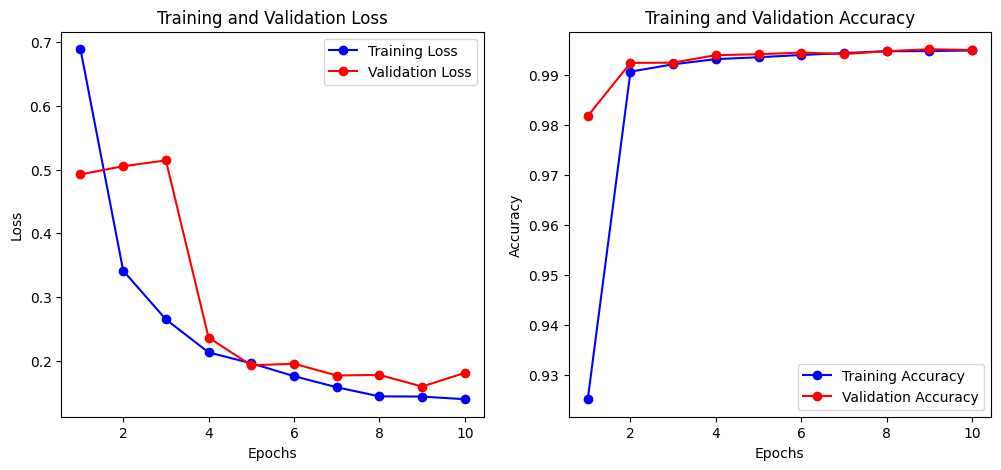

In [20]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    # Plot Loss Graph
    plt.figure(figsize=(12, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Call the function to plot
plot_training_history(history)


In [21]:
import numpy as np
from tensorflow.keras.metrics import MeanIoU

# Evaluate the model using X_test and Y_test_mask
test_loss, test_accuracy, *other_metrics = model.evaluate(X_test, Y_test_mask, verbose=1)

# Get predictions on the test set
predictions = model.predict(X_test, verbose=1)

# Convert predictions to binary (since they might be between 0 and 1, threshold at 0.5)
predictions_bin = (predictions > 0.5).astype(np.uint8)

# Define Dice Coefficient, IoU, and Pixel Accuracy
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + 1) / (np.sum(y_true) + np.sum(y_pred) + 1)

def iou_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / (union + 1e-6)  # Avoid division by zero

def pixel_accuracy(y_true, y_pred):
    correct_pixels = np.sum(y_true == y_pred)
    total_pixels = np.prod(y_true.shape)
    return correct_pixels / total_pixels

# Compute Dice, IoU, and Pixel Accuracy for the test set
dice_scores, iou_scores, pixel_accuracies = [], [], []

for i in range(len(X_test)):  
    dice_scores.append(dice_coefficient(Y_test_mask[i], predictions_bin[i]))
    iou_scores.append(iou_score(Y_test_mask[i], predictions_bin[i]))
    pixel_accuracies.append(pixel_accuracy(Y_test_mask[i], predictions_bin[i]))

# Calculate the average metrics
avg_dice = np.mean(dice_scores)
avg_iou = np.mean(iou_scores)
avg_pixel_acc = np.mean(pixel_accuracies)

# Print the results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Average Dice Coefficient: {avg_dice:.4f}")
print(f"Average IoU Score: {avg_iou:.4f}")
print(f"Average Pixel Accuracy: {avg_pixel_acc:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9945 - loss: 0.1748
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step
Test Accuracy: 0.9948
Average Dice Coefficient: 0.7600
Average IoU Score: 0.3175
Average Pixel Accuracy: 0.9948


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


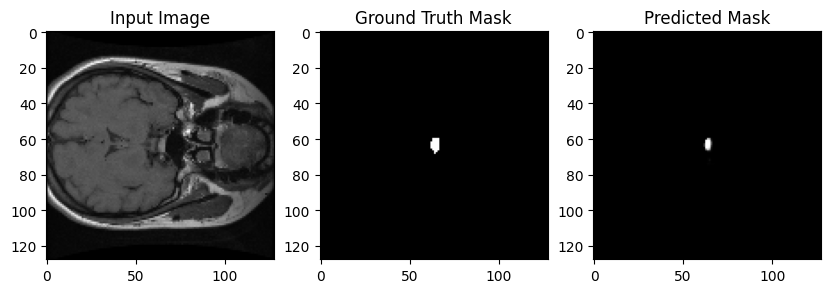

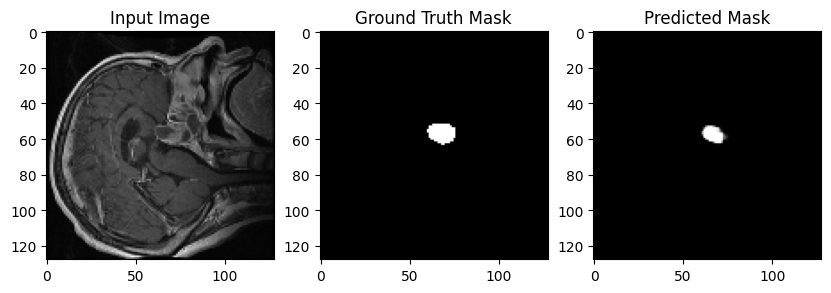

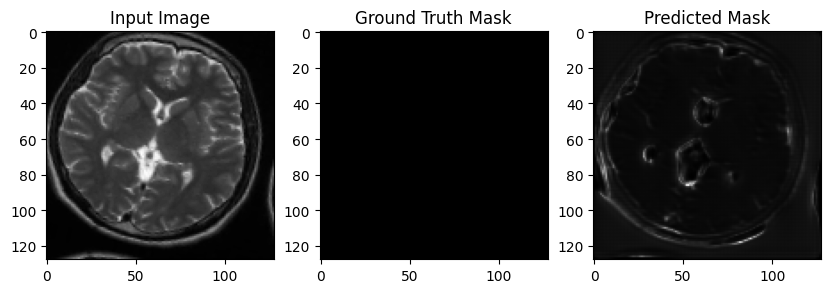

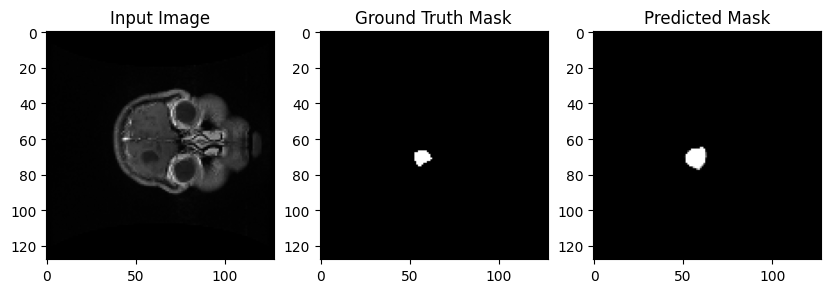

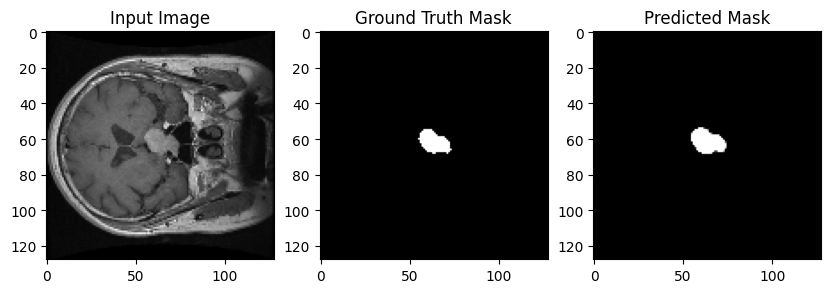

In [23]:
def visualize_predictions(model, X_test, y_test, num_samples=5):
    predictions = model.predict(X_test[:num_samples])
    
    for i in range(num_samples):
        plt.figure(figsize=(10, 3))
        
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(X_test[i].squeeze(), cmap='gray')
        
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(y_test[i].squeeze(), cmap='gray')
        
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        
        plt.show()

visualize_predictions(model, X_test, Y_test_mask)

In [24]:
# Predict Tumor Segmentation using the U-Net model
predicted_masks = model.predict(X_test)  # Assuming X_test contains MRI images

# Convert predictions to binary masks (thresholding)
predicted_masks_binary = (predicted_masks > 0.5).astype(np.uint8)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


In [25]:
import numpy as np

def compute_tumor_size(mask):
    return np.sum(mask)  # Count tumor pixels in the mask

tumor_sizes = [compute_tumor_size(mask) for mask in predicted_masks_binary]

# Normalize by image size (assuming 128x128 images)
tumor_percentages = [(size / (128 * 128)) * 100 for size in tumor_sizes]

# Find severity thresholds using percentiles (33% and 66%)
mild_threshold = np.percentile(tumor_percentages, 33)
moderate_threshold = np.percentile(tumor_percentages, 66)

def classify_tumor_severity(tumor_percentage):
    if tumor_percentage <= mild_threshold:
        return "Mild"
    elif tumor_percentage <= moderate_threshold:
        return "Moderate"
    else:
        return "Severe"

# Assign severity labels
tumor_severity_labels = [classify_tumor_severity(p) for p in tumor_percentages]

# Print severity distribution
unique, counts = np.unique(tumor_severity_labels, return_counts=True)
severity_distribution = dict(zip(unique, counts))

print("Tumor Severity Distribution:", severity_distribution)


Tumor Severity Distribution: {'Mild': 508, 'Moderate': 160, 'Severe': 345}


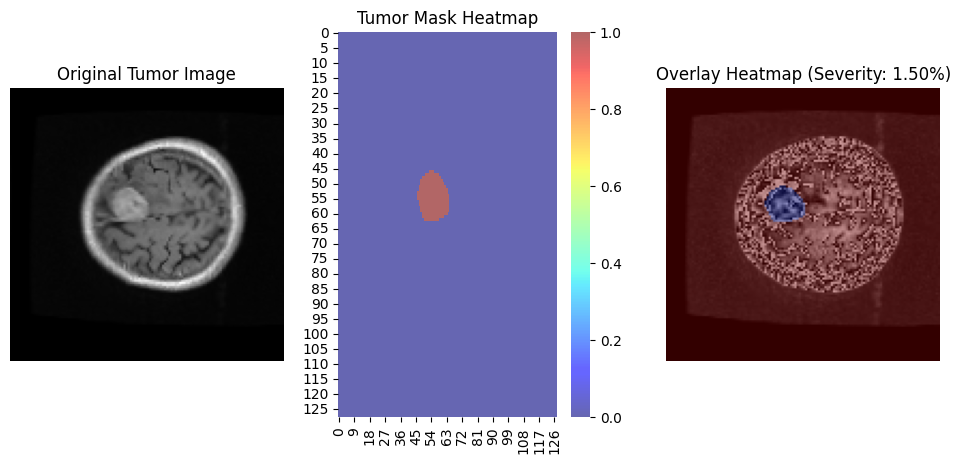

In [26]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Select a sample index for visualization
sample_idx = 10  # Change this for different samples

# Extract the image and mask
tumor_image = X_test[sample_idx].squeeze()  # Grayscale MRI image
tumor_mask = predicted_masks_binary[sample_idx].squeeze()  # Segmented mask

# Compute Tumor Severity
tumor_size = np.sum(tumor_mask)
severity_score = (tumor_size / (128 * 128)) * 100  # Normalize by image size

# Convert Tumor Mask to a Heatmap
heatmap = cv2.applyColorMap((tumor_mask * 255).astype(np.uint8), cv2.COLORMAP_JET)

# Convert Tumor Image to uint8 for proper overlay
tumor_image_uint8 = (tumor_image * 255).astype(np.uint8)
tumor_image_bgr = cv2.cvtColor(tumor_image_uint8, cv2.COLOR_GRAY2BGR)

# Overlay Heatmap on Original Image
overlay = cv2.addWeighted(tumor_image_bgr, 0.6, heatmap, 0.4, 0)

# Plot the Results
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(tumor_image, cmap="gray")
plt.title("Original Tumor Image")
plt.axis("off")

plt.subplot(1, 3, 2)
sns.heatmap(tumor_mask, cmap="jet", alpha=0.6)
plt.title("Tumor Mask Heatmap")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title(f"Overlay Heatmap (Severity: {severity_score:.2f}%)")
plt.axis("off")

plt.show()


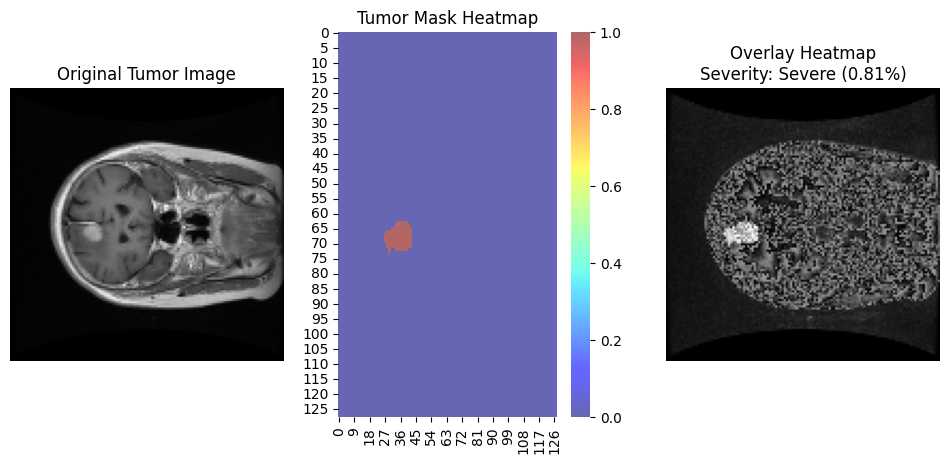

In [33]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def compute_tumor_size(mask):
    return np.sum(mask)  # Count tumor pixels in the mask

# Compute tumor sizes
tumor_sizes = [compute_tumor_size(mask) for mask in predicted_masks_binary]

# Normalize by image size (assuming 128x128 images)
tumor_percentages = [(size / (128 * 128)) * 100 for size in tumor_sizes]

# Compute severity thresholds
mild_threshold = np.percentile(tumor_percentages, 33)
moderate_threshold = np.percentile(tumor_percentages, 66)

def classify_tumor_severity(tumor_percentage):
    if tumor_percentage <= mild_threshold:
        return "Mild"
    elif tumor_percentage <= moderate_threshold:
        return "Moderate"
    else:
        return "Severe"

# Assign severity labels
tumor_severity_labels = [classify_tumor_severity(p) for p in tumor_percentages]

# Select a sample index for visualization
sample_idx = 99  # Change this for different samples

# Extract the image and mask
tumor_image = X_test[sample_idx].squeeze()  # Grayscale MRI image
tumor_mask = predicted_masks_binary[sample_idx].squeeze()  # Segmented mask

# Compute severity for the selected image
tumor_size = np.sum(tumor_mask)
tumor_percentage = (tumor_size / (128 * 128)) * 100
severity_label = classify_tumor_severity(tumor_percentage)

# Choose color map based on severity
colormap_dict = {
    "Mild": cv2.COLORMAP_COOL,
    "Moderate": cv2.COLORMAP_JET,
    "Severe": cv2.COLORMAP_HOT
}
selected_colormap = colormap_dict[severity_label]

# Convert Tumor Mask to a Heatmap
heatmap = cv2.applyColorMap((tumor_mask * 255).astype(np.uint8), selected_colormap)

# Convert Tumor Image to uint8 for overlay
tumor_image_uint8 = (tumor_image * 255).astype(np.uint8)
tumor_image_bgr = cv2.cvtColor(tumor_image_uint8, cv2.COLOR_GRAY2BGR)

# Overlay Heatmap on Original Image
overlay = cv2.addWeighted(tumor_image_bgr, 0.6, heatmap, 0.4, 0)

# Plot Results
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(tumor_image, cmap="gray")
plt.title("Original Tumor Image")
plt.axis("off")

plt.subplot(1, 3, 2)
sns.heatmap(tumor_mask, cmap="jet", alpha=0.6)
plt.title("Tumor Mask Heatmap")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title(f"Overlay Heatmap\nSeverity: {severity_label} ({tumor_percentage:.2f}%)")
plt.axis("off")

plt.show()


In [ ]:
'''import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Compute the Dice Coefficient.
    Args:
        y_true: Ground truth labels, shape (batch_size, height, width, 1).
        y_pred: Predicted labels, shape (batch_size, height, width, 1).
        smooth: Smoothing factor to avoid division by zero.
    Returns:
        Dice Coefficient.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])

    dice = (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)


def dice_coefficient(y_true, y_pred):
    """
    Compute Dice Coefficient for segmentation evaluation.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    smooth = 1e-6  # To avoid division by zero

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    return (2. * intersection + smooth) / (union + smooth)
def dice_bce_loss(y_true, y_pred, bce_weight=0.5, dice_weight=0.5):
    """
    Compute the combined Dice + Binary Cross-Entropy Loss.
    Args:
        y_true: Ground truth labels, shape (batch_size, height, width, 1).
        y_pred: Predicted labels, shape (batch_size, height, width, 1).
        bce_weight: Weight for the BCE loss component.
        dice_weight: Weight for the Dice loss component.
    Returns:
        Combined Dice + BCE Loss.
    """
    bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice_loss = 1 - dice_coefficient(y_true, y_pred)  # ✅ FIXED: Removed extra argument

    combined_loss = (bce_weight * bce_loss) + (dice_weight * dice_loss)
    return combined_loss'''
